- load processed data for GCF_000011065.1
- train a TXpredict model based on this bacteria strain

In [2]:
import numpy as np
import pandas as pd
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import math

### model definition

In [14]:
import sys
import os

scripts_path = os.path.join("..", "scripts")
sys.path.append(scripts_path)

from model import (
    PositionalEncoding,
    TransformerModel,
    CombinedModel
)

model1_params = {
            'input_dim': 1301,  
            'num_heads': 4,
            'num_layers': 1,
            'dim_feedforward': 128,  
            'dropout': 0.0
        }

combined_dim = 256 
output_dim = 1 

model = CombinedModel(model1_params, combined_dim, output_dim).to(device)


### data loading

In [5]:
import os
import numpy as np
import torch
import pandas as pd

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Directory containing all subfolders
base_path = "../example_data/GSE251676/"

# Get a list of folder names under `path_to_folder`
dataset_ids = ["GCF_000011065.1"]

# Lists to store combined data
X_list = []
Y_list = []
dataset_labels = []
output_dims = []

# Iterate over each dataset folder
for idx, dataset_id in enumerate(dataset_ids):  
    print(f"\nReading data from: {base_path}")

    # Construct file paths
    embeddings_path = os.path.join(base_path, f"{dataset_id}_filtered_embeddings.txt")
    meta_path = os.path.join(base_path, f"{dataset_id}_filtered_meta.txt")
    tpm_path = os.path.join(base_path, f"{dataset_id}_filtered_log_tpm.csv")

    # Load embeddings and meta
    if not (os.path.exists(embeddings_path) and os.path.exists(meta_path) and os.path.exists(tpm_path)):
        print("  Missing one or more required files. Skipping this dataset.")
        continue

    # Read embeddings and meta
    X_embedding = np.loadtxt(embeddings_path)
    X_meta = np.loadtxt(meta_path)

    # Combine embeddings + meta as final feature matrix X
    X = np.hstack([X_embedding, X_meta])

    # Read TPM (log_tpm) data and drop the first column if it's just an index
    tpm_df = pd.read_csv(tpm_path)
    Y = tpm_df.iloc[:, 1:].values  # use all columns except the first (assumes the first column is gene_id or an index)
    conditions = Y.shape[1]

    # If there's more than 1 condition in Y, do some filtering
    if conditions > 1:
        # Now reduce Y to single-column by taking row-wise mean
        row_means = np.mean(Y, axis=1, keepdims=True)
        Y = row_means

    # Collect dataset-wise results
    X_list.append(X)
    Y_list.append(Y)
    dataset_labels.extend([idx] * X.shape[0])

    # Track output dimensionality (often 1 if you reduce to row means)
    output_dims.append(Y.shape[1])
    print(f"  Genes: {Y.shape[0]}, Conditions: {conditions}, X shape: {X.shape}, Y shape: {Y.shape}")

print("\nData loading complete!")

Using device: cuda

Reading data from: ../example_data/GSE251676/
  Genes: 4618, Conditions: 64, X shape: (4618, 1301), Y shape: (4618, 1)

Data loading complete!


### model training

In [6]:
import os
import random
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

Training set: 3694 samples
Test set    : 924 samples
Epoch [1/5] - Train Loss: 0.4158
Epoch [2/5] - Train Loss: 0.4086
Epoch [3/5] - Train Loss: 0.3869
Epoch [4/5] - Train Loss: 0.3659
Epoch [5/5] - Train Loss: 0.3652
Spearman Correlation: 0.6674 (p-value=3.48e-120)
Pearson  Correlation: 0.6818 (p-value=2.439e-127)


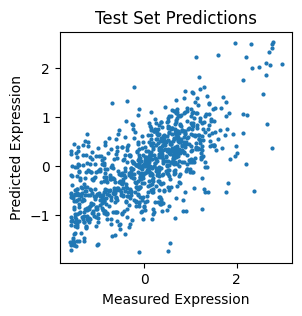

Model saved to ../example_data/GSE251676/trained_model.pth


In [16]:
# --------------------------------------------------------------------------
# Convert data to PyTorch tensors
# --------------------------------------------------------------------------
X_tensor = torch.FloatTensor(np.vstack(X))
Y_tensor = torch.FloatTensor(np.vstack(Y))

# --------------------------------------------------------------------------
# Split into train and test sets (80/20) with one random seed
# --------------------------------------------------------------------------
seed = 42
random.seed(seed)
torch.manual_seed(seed)

X_train, X_test, Y_train, Y_test = train_test_split(
    X_tensor, Y_tensor, test_size=0.2, random_state=seed
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set    : {X_test.shape[0]} samples")

# --------------------------------------------------------------------------
# Create PyTorch DataLoader
# --------------------------------------------------------------------------
train_dataset = TensorDataset(X_train, Y_train)
test_dataset  = TensorDataset(X_test,  Y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002)
criterion = nn.MSELoss()

# --------------------------------------------------------------------------
# Training loop
# --------------------------------------------------------------------------
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    for inputs, targets in train_loader:
        inputs  = inputs.to(device)     # if your model is on GPU
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_loss:.4f}")

# --------------------------------------------------------------------------
# Evaluation on test set
# --------------------------------------------------------------------------
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs  = inputs.to(device)
        targets = targets.to(device)

        preds = model(inputs)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

all_preds    = np.vstack(all_preds)
all_targets  = np.vstack(all_targets)

# Calculate correlations
spearman_corr = scipy.stats.spearmanr(all_preds.flatten(), all_targets.flatten())
pearson_corr  = scipy.stats.pearsonr(all_preds.flatten(),  all_targets.flatten())
print(f"Spearman Correlation: {spearman_corr.correlation:.4f} (p-value={spearman_corr.pvalue:.4g})")
print(f"Pearson  Correlation: {pearson_corr[0]:.4f} (p-value={pearson_corr[1]:.4g})")

# --------------------------------------------------------------------------
# Plot predicted vs. actual (test set) as a scatter plot
# --------------------------------------------------------------------------
plt.figure(figsize=(3, 3))
plt.scatter(all_targets, all_preds, s=4)
plt.xlabel("Measured Expression")
plt.ylabel("Predicted Expression")
plt.title("Test Set Predictions")
plt.show()

# --------------------------------------------------------------------------
# Save the trained model
# --------------------------------------------------------------------------
save_model_path = "../example_data/GSE251676/trained_model.pth"
torch.save(model.state_dict(), save_model_path)
print(f"Model saved to {save_model_path}")